# **Quora Question Pairs - LSTM(An RNN Model)**

# Initial Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df = pd.read_csv(r"../questions.csv")
file_path = '/content/drive/My Drive/questions.csv'
df = pd.read_csv(file_path)
df.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
new_df = df.sample(400,random_state=2)
new_df.shape

(400, 6)

# Adding More Features

# 1. Length Of Questions

In [ ]:
#feature-1
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
339499,339499,665522,665523,Why was Cyrus Mistry removed as the Chairman o...,Why did the Tata Sons sacked Cyrus Mistry?,1,58,42
289521,289521,568878,568879,By what age would you think a man should be ma...,When my wrist is extended I feel a shock and b...,0,52,105
4665,4665,9325,9326,How would an arbitrageur seek to capitalize gi...,How would an arbitrageur seek to capitalize gi...,0,125,124
54203,54203,107861,107862,Why did Quora mark my question as incomplete?,Why does Quora detect my question as an incomp...,1,45,60
132566,132566,262554,91499,What is it like working with Pivotal Labs as a...,What's it like to work at Pivotal Labs?,0,54,39


# 2. Number Of Words In Both Questions

In [ ]:
#feature-2

#Encounter NaN Values
new_df['question1'] = new_df['question1'].fillna('')
new_df['question2'] = new_df['question2'].fillna('')

new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
339499,339499,665522,665523,Why was Cyrus Mistry removed as the Chairman o...,Why did the Tata Sons sacked Cyrus Mistry?,1,58,42,11,8
289521,289521,568878,568879,By what age would you think a man should be ma...,When my wrist is extended I feel a shock and b...,0,52,105,11,22
4665,4665,9325,9326,How would an arbitrageur seek to capitalize gi...,How would an arbitrageur seek to capitalize gi...,0,125,124,24,24
54203,54203,107861,107862,Why did Quora mark my question as incomplete?,Why does Quora detect my question as an incomp...,1,45,60,8,10
132566,132566,262554,91499,What is it like working with Pivotal Labs as a...,What's it like to work at Pivotal Labs?,0,54,39,11,8


# 3. Number Of Common Words

In [ ]:
#Feature-3
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [ ]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
339499,339499,665522,665523,Why was Cyrus Mistry removed as the Chairman o...,Why did the Tata Sons sacked Cyrus Mistry?,1,58,42,11,8,4
289521,289521,568878,568879,By what age would you think a man should be ma...,When my wrist is extended I feel a shock and b...,0,52,105,11,22,2
4665,4665,9325,9326,How would an arbitrageur seek to capitalize gi...,How would an arbitrageur seek to capitalize gi...,0,125,124,24,24,20
54203,54203,107861,107862,Why did Quora mark my question as incomplete?,Why does Quora detect my question as an incomp...,1,45,60,8,10,5
132566,132566,262554,91499,What is it like working with Pivotal Labs as a...,What's it like to work at Pivotal Labs?,0,54,39,11,8,3


# 4. Number Of Total Words

In [ ]:
#Feature-4
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

In [ ]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
339499,339499,665522,665523,Why was Cyrus Mistry removed as the Chairman o...,Why did the Tata Sons sacked Cyrus Mistry?,1,58,42,11,8,4,19
289521,289521,568878,568879,By what age would you think a man should be ma...,When my wrist is extended I feel a shock and b...,0,52,105,11,22,2,32
4665,4665,9325,9326,How would an arbitrageur seek to capitalize gi...,How would an arbitrageur seek to capitalize gi...,0,125,124,24,24,20,42
54203,54203,107861,107862,Why did Quora mark my question as incomplete?,Why does Quora detect my question as an incomp...,1,45,60,8,10,5,18
132566,132566,262554,91499,What is it like working with Pivotal Labs as a...,What's it like to work at Pivotal Labs?,0,54,39,11,8,3,19


# 5. word share= word common / word total

In [ ]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
339499,339499,665522,665523,Why was Cyrus Mistry removed as the Chairman o...,Why did the Tata Sons sacked Cyrus Mistry?,1,58,42,11,8,4,19,0.21
289521,289521,568878,568879,By what age would you think a man should be ma...,When my wrist is extended I feel a shock and b...,0,52,105,11,22,2,32,0.06
4665,4665,9325,9326,How would an arbitrageur seek to capitalize gi...,How would an arbitrageur seek to capitalize gi...,0,125,124,24,24,20,42,0.48
54203,54203,107861,107862,Why did Quora mark my question as incomplete?,Why does Quora detect my question as an incomp...,1,45,60,8,10,5,18,0.28
132566,132566,262554,91499,What is it like working with Pivotal Labs as a...,What's it like to work at Pivotal Labs?,0,54,39,11,8,3,19,0.16


# Data Visualizaton

minimum characters 18
maximum characters 199
average num of characters 61


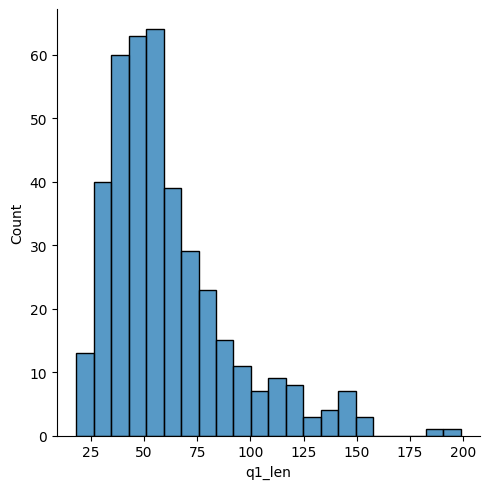

In [ ]:
# Analysis of features
sns.displot(new_df['q1_len'])
print('minimum characters',new_df['q1_len'].min())
print('maximum characters',new_df['q1_len'].max())
print('average num of characters',int(new_df['q1_len'].mean()))

minimum characters 16
maximum characters 239
average num of characters 61


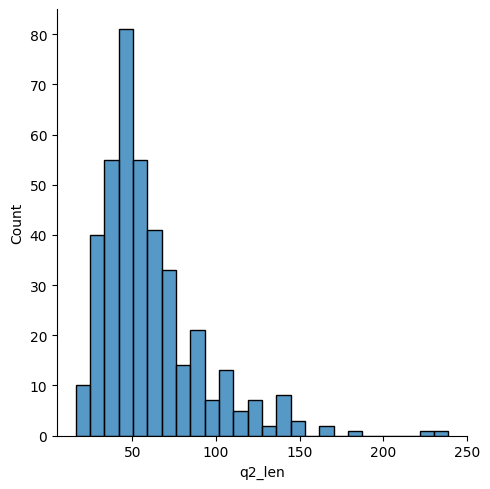

In [ ]:
sns.displot(new_df['q2_len'])
print('minimum characters',new_df['q2_len'].min())
print('maximum characters',new_df['q2_len'].max())
print('average num of characters',int(new_df['q2_len'].mean()))

minimum words 4
maximum words 39
average num of words 11


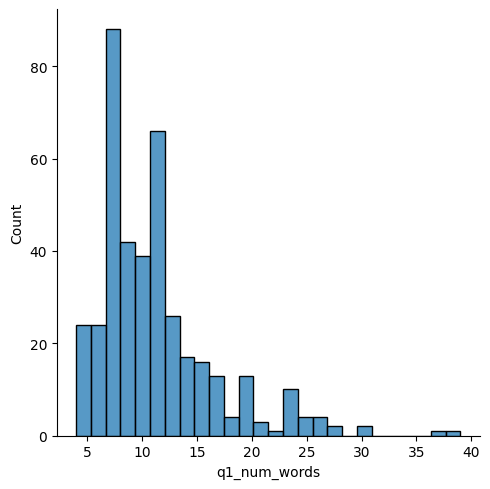

In [ ]:
sns.displot(new_df['q1_num_words'])
print('minimum words',new_df['q1_num_words'].min())
print('maximum words',new_df['q1_num_words'].max())
print('average num of words',int(new_df['q1_num_words'].mean()))

minimum words 3
maximum words 48
average num of words 11


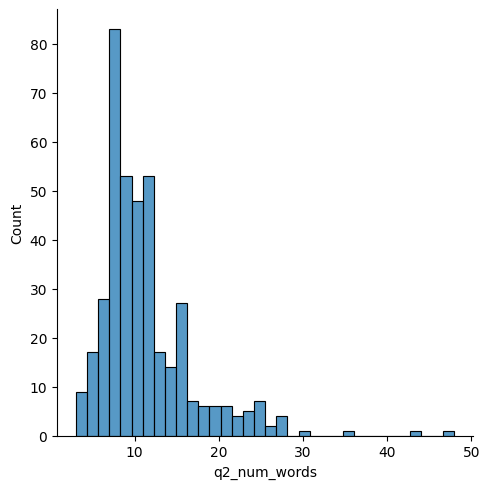

In [ ]:
sns.displot(new_df['q2_num_words'])
print('minimum words',new_df['q2_num_words'].min())
print('maximum words',new_df['q2_num_words'].max())
print('average num of words',int(new_df['q2_num_words'].mean()))

<ipython-input-46-e370b529e03d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate')
<ipython-input-46-e370b529e03d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'],label='du

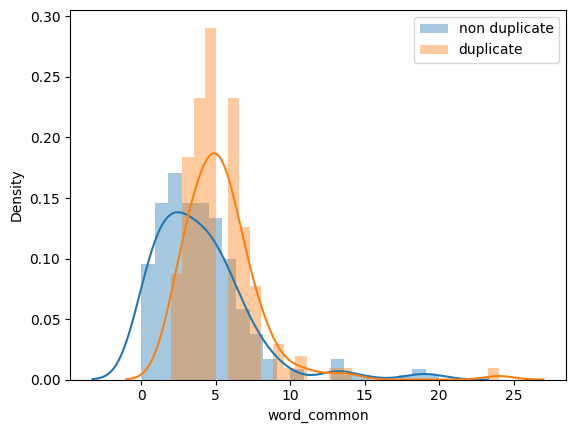

In [ ]:
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-47-babee9c71a44>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
<ipython-input-47-babee9c71a44>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'],label='dupl

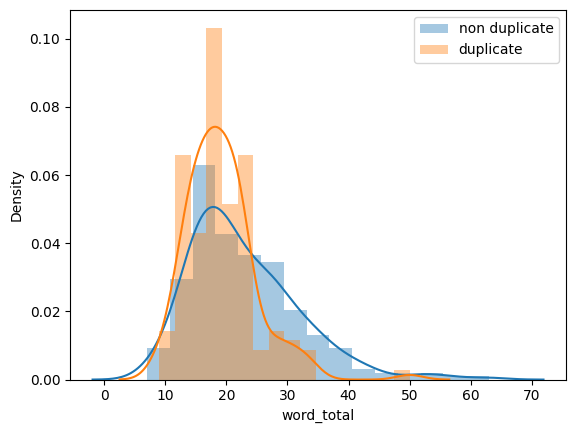

In [ ]:
# total words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-48-b7e81f19ad7c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
<ipython-input-48-b7e81f19ad7c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'],label='dupl

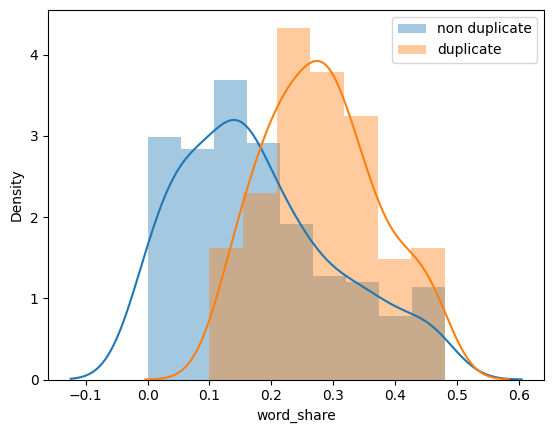

In [ ]:
# word share
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

# Data Prepration

In [ ]:
ques_df = new_df[['question1','question2',]]
ques_df1 = new_df[['is_duplicate']]
ques_df.head()

,question1,question2
339499,Why was Cyrus Mistry removed as the Chairman o...,Why did the Tata Sons sacked Cyrus Mistry?
289521,By what age would you think a man should be ma...,When my wrist is extended I feel a shock and b...
4665,How would an arbitrageur seek to capitalize gi...,How would an arbitrageur seek to capitalize gi...
54203,Why did Quora mark my question as incomplete?,Why does Quora detect my question as an incomp...
132566,What is it like working with Pivotal Labs as a...,What's it like to work at Pivotal Labs?


# NLTK Necessary Packages

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert nltk POS tags to wordnet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = [(word, get_wordnet_pos(tag)) for word, tag in nltk_tagged]
    lemmatized_sentence = [lemmatizer.lemmatize(word, tag) for word, tag in wordnet_tagged]
    return lemmatized_sentence


In [ ]:
# nltk_data_path = '/kaggle/working/'
# nltk_data_path = r'C:\Users\Vasu\AppData\Roaming\nltk_data\'
nltk_data_path = r'/root/nltk_data'

nltk.data.path.append(nltk_data_path)

# Ensure the data can be accessed
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('averaged_perceptron_tagger', download_dir=nltk_data_path)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
import zipfile
import os

# Path to the zip file and the extraction directory
zip_file_path = '/root/nltk_data/corpora/wordnet.zip'
extraction_dir = '/root/nltk_data/corpora'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)


# Lemmatization And Word2Vec

In [ ]:
# Lemmatize and tokenize the questions
questions = list(ques_df['question1']) + list(ques_df['question2'])
lemmatized_questions = [' '.join(lemmatize_sentence(q)) for q in questions]

# Fit the tokenizer on the lemmatized questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lemmatized_questions)
vocab_size = len(tokenizer.word_index) + 1

# Convert questions to sequences of integers
q1_seq = tokenizer.texts_to_sequences(ques_df['question1'].apply(lambda x: ' '.join(lemmatize_sentence(x))))
q2_seq = tokenizer.texts_to_sequences(ques_df['question2'].apply(lambda x: ' '.join(lemmatize_sentence(x))))

# Pad the sequences to ensure they have the same length
max_seq_length = max(max(len(seq) for seq in q1_seq), max(len(seq) for seq in q2_seq))
q1_pad = pad_sequences(q1_seq, maxlen=max_seq_length, padding='post')
q2_pad = pad_sequences(q2_seq, maxlen=max_seq_length, padding='post')

# Train Word2Vec model
word2vec_model = Word2Vec([q.split() for q in lemmatized_questions], vector_size=100, window=5, min_count=1, workers=4)

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Create LSTM Architecture

In [ ]:
def create_lstm_model(input_length, vocab_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=input_length * 2, trainable=False))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Model Training


In [ ]:
# Combine q1 and q2 padded sequences for training
X = np.concatenate([q1_pad, q2_pad] ,axis = 1)

# Extract the target variable
y = ques_df1['is_duplicate'].values

# Define K-Fold cross-validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)
cv_scores = []
histories = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_lstm_model(input_length=max_seq_length, vocab_size=vocab_size, embedding_matrix=embedding_matrix)
    history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    cv_scores.append(val_accuracy)
    histories.append(history)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6293 - loss: 0.6700 - val_accuracy: 0.6300 - val_loss: 0.6641
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 826ms/step - accuracy: 0.6927 - loss: 0.6189 - val_accuracy: 0.6300 - val_loss: 0.7274
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6802 - loss: 0.6622 - val_accuracy: 0.6300 - val_loss: 0.7111
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step - accuracy: 0.6963 - loss: 0.6230 - val_accuracy: 0.6300 - val_loss: 0.6638
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step - accuracy: 0.6849 - loss: 0.6201 - val_accuracy: 0.6300 - val_loss: 0.6562
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 852ms/step - accuracy: 0.4669 - loss: 0.6940 - val_accuracy: 0.6900 - val_loss: 0.6390
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - accuracy: 0.6655 - loss: 0.6456 - val_accuracy: 0.6900 - val_loss: 0.6294
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step - accuracy: 0.6484 - loss: 0.6519 - val_accuracy: 0.6900 - val_loss: 0.6428
Epoch 4/5
4/4 

In [ ]:
from tensorflow.keras.models import load_model
import os

# Directory to save the model in Google Drive
model_dir = '/content/drive/My Drive/Colab_Notebooks/Models/lstm/'

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the trained model after training
model_filename = os.path.join(model_dir, 'lstm_question_similarity_model.keras')  # Use .keras extension
model.save(model_filename)  # Save the model in Keras format
print(f"Model saved as '{model_filename}'.")

# # --- Loading the model ---
# # Load the saved model
# loaded_model = load_model(model_filename)
# print(f"Model loaded from '{model_filename}'.")

# # Function to predict similarity between two questions
# def predict_similarity(q1, q2, tokenizer, max_seq_length, model):
#     # Lemmatize and tokenize the questions
#     q1_lemmatized = ' '.join(lemmatize_sentence(q1))  # Replace with your lemmatization function
#     q2_lemmatized = ' '.join(lemmatize_sentence(q2))  # Replace with your lemmatization function

#     # Convert the questions to sequences of integers
#     q1_seq = tokenizer.texts_to_sequences([q1_lemmatized])
#     q2_seq = tokenizer.texts_to_sequences([q2_lemmatized])

#     # Pad the sequences to ensure they have the same length
#     q1_pad = pad_sequences(q1_seq, maxlen=max_seq_length, padding='post')
#     q2_pad = pad_sequences(q2_seq, maxlen=max_seq_length, padding='post')

#     # Concatenate the sequences (q1 and q2) for prediction
#     X = np.concatenate([q1_pad, q2_pad], axis=1)

#     # Predict similarity (output is 0 or 1 indicating similarity or dissimilarity)
#     similarity_score = model.predict(X)

#     return similarity_score[0][0]

# # Example questions to check similarity
# q1 = 'How do I read and find my YouTube comments?'
# q2 = 'How can I see all my Youtube comments?'

# # Predict similarity between two questions
# similarity_score = predict_similarity(q1, q2, tokenizer, max_seq_length, loaded_model)
# print(f"Similarity score between q1 and q2: {similarity_score:.4f}")


Model saved as '/content/drive/My Drive/Colab_Notebooks/Models/lstm/lstm_question_similarity_model.keras'.


In [ ]:
# ## LOAD MODEL
# import numpy as np
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Combine q1 and q2 padded sequences for training
# X = np.concatenate([q1_pad, q2_pad], axis=1)

# # Extract the target variable
# y = ques_df1['is_duplicate'].values

# # Define K-Fold cross-validation
# kf = KFold(n_splits=2, shuffle=True, random_state=42)
# cv_scores = []
# histories = []
# fold = 0  # Initialize fold variable to track folds

# # List to store all models after each fold
# models = []

# for train_index, val_index in kf.split(X):
#     fold += 1  # Increment fold
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]

#     # Create the LSTM model
#     model = create_lstm_model(input_length=max_seq_length, vocab_size=vocab_size, embedding_matrix=embedding_matrix)

#     # Train the model
#     history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=1)

#     # Save the model after each fold
#     model_filename = f'lstm_model_fold_{fold}.h5'
#     model.save(model_filename)
#     print(f'Model saved as {model_filename}')

#     # Append the trained model to the models list
#     models.append(model)

#     # Evaluate the model
#     val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
#     cv_scores.append(val_accuracy)
#     histories.append(history)

# # Print the average cross-validation score
# print(f"Average CV Accuracy: {np.mean(cv_scores):.4f}")

# # --- Load models and test on two sentences ---
# # Load all the models from each fold
# loaded_models = []
# for i in range(1, fold + 1):
#     model_filename = f'lstm_model_fold_{i}.h5'
#     loaded_model = load_model(model_filename)
#     loaded_models.append(loaded_model)
#     print(f'Loaded model from {model_filename}')

# # Preprocess and pad the two sentences for prediction
# q1_test = ["This is the first sentence."]
# q2_test = ["This is the second sentence."]
# # Assuming you have the tokenizer and max_seq_length from the training phase
# X_test = preprocess_and_pad(q1_test + q2_test, max_seq_length, tokenizer)

# # Split into q1 and q2 for prediction
# q1_test_pad = X_test[:len(q1_test)]
# q2_test_pad = X_test[len(q1_test):]

# # Predict using all models and average the results
# predictions = []

# for model in loaded_models:
#     # Concatenate the padded sequences of q1 and q2 for each model
#     X_test_combined = np.concatenate([q1_test_pad, q2_test_pad], axis=1)
#     preds = model.predict(X_test_combined)
#     predictions.append(preds)

# # Average the predictions across all folds
# average_predictions = np.mean(predictions, axis=0)

# # Print the averaged prediction for the two sentences
# print(f'Predicted probabilities: {average_predictions}')
# print(f'Predicted label: {int(average_predictions > 0.5)}')  # Threshold at 0.5 for binary classification


Cross-validation accuracy scores: [0.6299999952316284, 0.6899999976158142]
Mean cross-validation accuracy: 0.6599999964237213


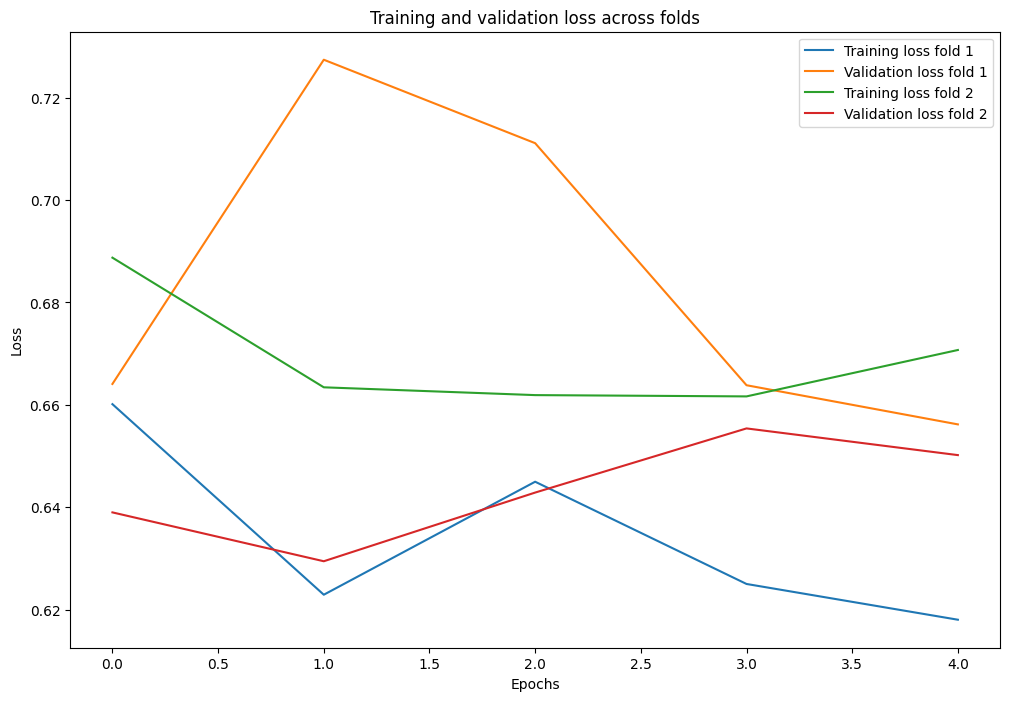

In [ ]:
# Print cross-validation scores
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {np.mean(cv_scores)}')

# Plot training and validation loss
plt.figure(figsize=(12, 8))

for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Training loss fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation loss fold {i+1}')

plt.title('Training and validation loss across folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# # --- Load models and test on two sentences ---
# # Load all the models from each fold

# from tensorflow.keras.models import load_model
# import os

# model_dir = '/content/drive/My Drive/Colab_Notebooks/Models/lstm/'
# loaded_models = []
# fold = 2

# for i in range(1, fold + 1):
#     model_filename = os.path.join(model_dir, f'lstm_model_fold_{i}.h5')
#     loaded_model = load_model(model_filename)
#     loaded_models.append(loaded_model)
#     print(f'Loaded model from {model_filename}')

# # Preprocess and pad the two sentences for prediction
# q1_test = ["How do I read and find my YouTube comments?"]
# q2_test = ["How can I see all my Youtube comments?"]
# # q1_test = ["Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?"]
# # q2_test = ["I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?"]
# # q1_test = ["How to train a Machine Learning model"]
# # q2_test = ["How do I train a model"]
# # Assuming you have the tokenizer and max_seq_length from the training phase
# def preprocess_and_pad(sentences, max_seq_length, tokenizer):
#     # Tokenize and pad the sentences
#     sequences = tokenizer.texts_to_sequences(sentences)
#     padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
#     return padded_sequences
# X_test = preprocess_and_pad(q1_test + q2_test, max_seq_length, tokenizer)

# # Split into q1 and q2 for prediction
# q1_test_pad = X_test[:len(q1_test)]
# q2_test_pad = X_test[len(q1_test):]

# # Predict using all models and average the results
# predictions = []

# for model in loaded_models:
#     # Concatenate the padded sequences of q1 and q2 for each model
#     X_test_combined = np.concatenate([q1_test_pad, q2_test_pad], axis=1)
#     preds = model.predict(X_test_combined)
#     predictions.append(preds)

# # Average the predictions across all folds
# average_predictions = np.mean(predictions, axis=0)

# # Print the averaged prediction for the two sentences
# print(f'Predicted probabilities: {average_predictions}')
# print(f'Predicted label: {int(average_predictions > 0.5)}')  # Threshold at 0.5 for binary classification

In [ ]:
from tensorflow.keras.models import load_model

# Path to the model file in Google Drive
model_filename = '/content/drive/My Drive/Colab_Notebooks/Models/lstm/lstm_question_similarity_model.keras'
loaded_model = load_model(model_filename)
print(f"Model loaded from '{model_filename}'.")

# Function to predict similarity between two questions
def predict_similarity(q1, q2, tokenizer, max_seq_length, model):
    # Lemmatize and tokenize the questions
    q1_lemmatized = ' '.join(lemmatize_sentence(q1))  # Replace with your lemmatization function
    q2_lemmatized = ' '.join(lemmatize_sentence(q2))  # Replace with your lemmatization function

    # Convert the questions to sequences of integers
    q1_seq = tokenizer.texts_to_sequences([q1_lemmatized])
    q2_seq = tokenizer.texts_to_sequences([q2_lemmatized])

    # Pad the sequences to ensure they have the same length
    q1_pad = pad_sequences(q1_seq, maxlen=max_seq_length, padding='post')
    q2_pad = pad_sequences(q2_seq, maxlen=max_seq_length, padding='post')

    # Concatenate the sequences (q1 and q2) for prediction
    X = np.concatenate([q1_pad, q2_pad], axis=1)

    # Predict similarity (output is 0 or 1 indicating similarity or dissimilarity)
    similarity_score = model.predict(X)

    return similarity_score[0][0]

# Example questions to check similarity
q1 = 'How do I read and find my YouTube comments?'
q2 = 'How can I see all my Youtube comments?'
# q2 = 'How do I read and find my YouTube comments?'

# Predict similarity between two questions
similarity_score = predict_similarity(q1, q2, tokenizer, max_seq_length, loaded_model)
print(f"Similarity score between q1 and q2: {similarity_score:.4f}")

Model loaded from '/content/drive/My Drive/Colab_Notebooks/Models/lstm/lstm_question_similarity_model.keras'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
Similarity score between q1 and q2: 0.4345
